In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import regionmask

This notebook plots the seasonal cycle of precipitation over India.

In [2]:
# DATA: GPCP precipitation (monthly, global)
loc = Path("/glade/work/brianpm/observations/gpcp")
ds = xr.open_dataset(loc / "precip.mon.mean.nc")
ds

<xarray.Dataset> Size: 22MB
Dimensions:    (lat: 72, lon: 144, time: 535, nv: 2)
Coordinates:
  * lat        (lat) float32 288B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon        (lon) float32 576B 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2023-07-01
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] 9kB ...
    lat_bnds   (lat, nv) float32 576B ...
    lon_bnds   (lon, nv) float32 1kB ...
    precip     (time, lat, lon) float32 22MB ...
Attributes: (12/18)
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    ...                    ...
    source:                https://www.ncei.noaa.gov/data/global-precipitatio...
    source_documentation:  https://www.ncdc.noaa.gov/cdr/atmospheric/precipit...
    NCO:                   4.6.9
    history:               Generated at NOAA/ESRL PSD Sep 9 2016 based on dat...
    References:            http://www.psl.noaa.gov/data/gridded/data.gpcp.html
    data_comment:          Interim data covers 2023/06 through latest.

In [3]:
# create a 'mask' of the AR6 regions (each will have an integer value)
# regionmask might have to download some data the first time
regions = regionmask.defined_regions.ar6.all.mask(ds.lon, ds.lat)

In [4]:
regions

<xarray.DataArray 'mask' (lat: 72, lon: 144)> Size: 83kB
array([[44., 44., 44., ..., 44., 44., 44.],
       [44., 44., 44., ..., 44., 44., 44.],
       [44., 44., 44., ..., 44., 44., 44.],
       ...,
       [46., 46., 46., ..., 46., 46., 46.],
       [46., 46., 46., ..., 46., 46., 46.],
       [46., 46., 46., ..., 46., 46., 46.]])
Coordinates:
  * lat      (lat) float32 288B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon      (lon) float32 576B 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Attributes:
    standard_name:  region
    flag_values:    [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18...
    flag_meanings:  GIC NWN NEN WNA CNA ENA NCA SCA CAR NWS NSA NES SAM SWS S...

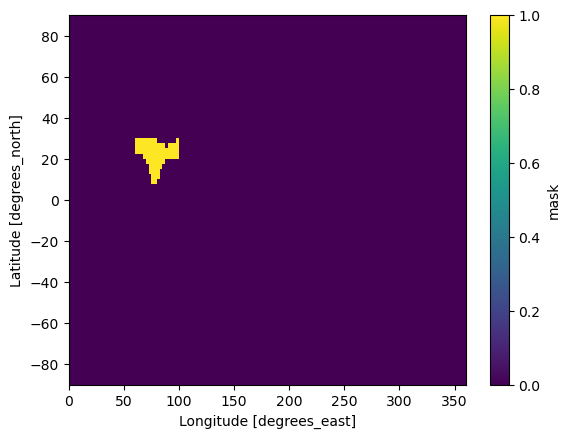

In [5]:
# check that we know which one is our region
# South Asia
(regions == 37).plot()

In [6]:
# Get precipitation data (time, lat, lon)
da = ds['precip']

# Step 1: Create a period pseudo-coordinate
# each 3-year chunk gets labeled with a value
da['period'] = ((da.time.dt.year - 1979) // 3).astype('int')

# Step 2: Get unique periods
periods = np.unique(da.period.values)

# Step 3: Calculate monthly averages for each period
period_monthly_means = []
for p in periods:
    period_data = da.where(da.period == p, drop=True)
    monthly_mean = period_data.groupby('time.month').mean('time')
    period_monthly_means.append(monthly_mean)

# Step 4: Combine all period monthly means
all_period_monthly_means = xr.concat(period_monthly_means, dim='period')


In [7]:
# select only the region we selected (37 = South Asia)
india = xr.where( (regions == 37), all_period_monthly_means, np.nan)

# area-weighted average
# this works because all the places not in region 37 are nan
# and xarray's `mean` method ignores nan
region_avg = india.weighted(np.cos(np.radians(india.lat))).mean(dim=('lat','lon'))

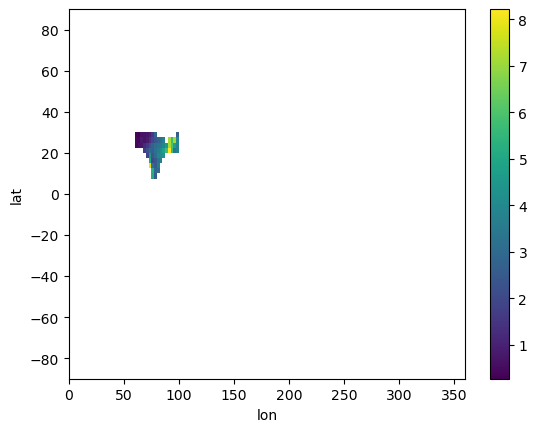

In [10]:
# Could just plot time mean precipitation in region like so (as a check)
xr.where( (regions==37), da, np.nan).mean(dim='time').plot()

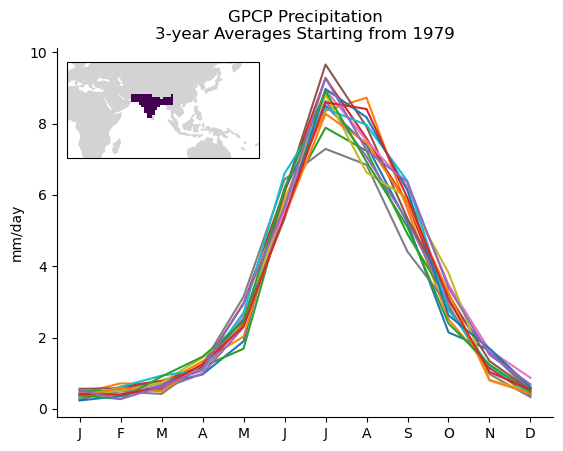

In [91]:
fig, ax = plt.subplots()
xax = np.arange(1,13)
for p in range(len(region_avg.period)):
    plt.plot(xax, region_avg[p,:])

ax.set_xticks(np.arange(1, 13))
ax.set_xticklabels(["J","F","M","A", "M", "J", "J", "A", "S", "O", "N", "D"])
ax.set_title("GPCP Precipitation\n3-year Averages Starting from 1979")
ax.set_ylabel("mm/day")


# Create the inset axes
axins = fig.add_axes([0.14, 0.6, 0.3, 0.3], projection=ccrs.PlateCarree())

import cartopy.feature as cfeature

# Add map features to the inset
axins.add_feature(cfeature.LAND, color='lightgray')
# axins.add_feature(cfeature.BORDERS)

# Set the extent of the inset map to show your region of interest
lon_min = 0
lon_max = 180
lat_min = -30
lat_max = 60
axins.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# color the exact region that is being selected
mlon, mlat = np.meshgrid(regions.lon, regions.lat)
axins.pcolormesh(mlon, mlat, xr.where(regions==37, 1, np.nan), transform=ccrs.PlateCarree())

ax.spines[['top','right']].set_visible(False)
